In [21]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import keras_tuner as kt
import matplotlib.pyplot as plt

In [22]:
# Define paths
dataset_dir = "D://SEM-4//PROJECTS//ML//DATASET//Archive"  # replace with the path to your dataset directory

In [23]:

# Image data generators with validation split
datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    validation_split=0.25,  # 25% for validation/testing
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [24]:
# Training generator
train_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(227, 227),
    batch_size=128,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

Found 8738 images belonging to 13 classes.


In [25]:
# Validation generator
val_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(227, 227),
    batch_size=128,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 2909 images belonging to 13 classes.


In [26]:
# Define the AlexNet architecture
def build_alexnet(input_shape, num_classes):
    model = Sequential()
    
    model.add(Conv2D(96, (11, 11), strides=4, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    
    model.add(Conv2D(256, (5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(384, (3, 3), padding='same', activation='relu'))
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
    
    model.add(Flatten())
    
    return model

In [27]:
# Define the model building function for Keras Tuner
def build_model(hp):
    model = build_alexnet((227, 227, 3), 13)
    
    # Tune the number of units in the Dense layers
    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(Dense(units=hp.Int('units_' + str(i), min_value=128, max_value=512, step=64),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_' + str(i), min_value=0.2, max_value=0.5, step=0.1)))
    
    model.add(Dense(13, activation='softmax'))  # 13 classes

    # Tune the learning rate for the optimizer
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [28]:
# Instantiate the tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=12,
    executions_per_trial=1,
    directory='alexnet_tuner_dir',
    project_name='alexnet_image_classification'
)

Reloading Tuner from alexnet_tuner_dir\alexnet_image_classification\tuner0.json


In [29]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [30]:
# Search for the best hyperparameters
tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,  # max epochs
    callbacks=[early_stopping]
)

In [31]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [32]:
# Build the best model
model = tuner.hypermodel.build(best_hps)

In [33]:
# Train the model with the optimal hyperparameters
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=50,  # you can adjust the number of epochs
    callbacks=[early_stopping]
)

Epoch 1/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.0900 - loss: 2.5451

C:\Users\garik\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


68/68 ━━━━━━━━━━━━━━━━━━━━ 852s 12s/step - accuracy: 0.0903 - loss: 2.5448 - val_accuracy: 0.1126 - val_loss: 2.5663
Epoch 2/50
 1/68 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.1797 - loss: 2.4022

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - accuracy: 0.1797 - loss: 2.4022 - val_accuracy: 0.1183 - val_loss: 2.5665
Epoch 3/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 747s 10s/step - accuracy: 0.1699 - loss: 2.4083 - val_accuracy: 0.1665 - val_loss: 2.5054
Epoch 4/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1719 - loss: 2.3967 - val_accuracy: 0.2366 - val_loss: 2.4522
Epoch 5/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 701s 10s/step - accuracy: 0.2243 - loss: 2.2923 - val_accuracy: 0.1562 - val_loss: 2.4729
Epoch 6/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.3047 - loss: 2.1843 - val_accuracy: 0.1398 - val_loss: 2.6387
Epoch 7/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 628s 9s/step - accuracy: 0.2361 - loss: 2.2498 - val_accuracy: 0.1705 - val_loss: 2.4664
Epoch 8/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - accuracy: 0.2578 - loss: 2.0973 - val_accuracy: 0.1505 - val_loss: 2.4737
Epoch 9/50
68/68 ━━━━━━━━━━━━━━━━━━━━ 641s 9s/step - accuracy: 0.2560 - loss: 2.2061 - val_accuracy: 0.1573 - val_loss: 

In [34]:
# Print training and validation accuracy for each epoch
for epoch, (train_acc, val_acc) in enumerate(zip(history.history['accuracy'], history.history['val_accuracy'])):
    print(f'Epoch {epoch + 1}: Training Accuracy: {train_acc * 100:.2f}%, Validation Accuracy: {val_acc * 100:.2f}%')

Epoch 1: Training Accuracy: 10.89%, Validation Accuracy: 11.26%
Epoch 2: Training Accuracy: 17.97%, Validation Accuracy: 11.83%
Epoch 3: Training Accuracy: 17.82%, Validation Accuracy: 16.65%
Epoch 4: Training Accuracy: 17.19%, Validation Accuracy: 23.66%
Epoch 5: Training Accuracy: 22.33%, Validation Accuracy: 15.62%
Epoch 6: Training Accuracy: 30.47%, Validation Accuracy: 13.98%
Epoch 7: Training Accuracy: 24.37%, Validation Accuracy: 17.05%
Epoch 8: Training Accuracy: 25.78%, Validation Accuracy: 15.05%
Epoch 9: Training Accuracy: 26.49%, Validation Accuracy: 15.73%


In [35]:
# Get the final training accuracy
final_training_accuracy = history.history['accuracy'][-1]
print(f'Final Training Accuracy: {final_training_accuracy * 100:.2f}%')

Final Training Accuracy: 26.49%


In [36]:
# You can also get the final validation accuracy
final_validation_accuracy = history.history['val_accuracy'][-1]
print(f'Final Validation Accuracy: {final_validation_accuracy * 100:.2f}%')

Final Validation Accuracy: 15.73%


In [50]:
# Plot training & validation accuracy values
plt.figure(figsize=(12,4))

<Figure size 400x400 with 0 Axes>

<Figure size 400x400 with 0 Axes>

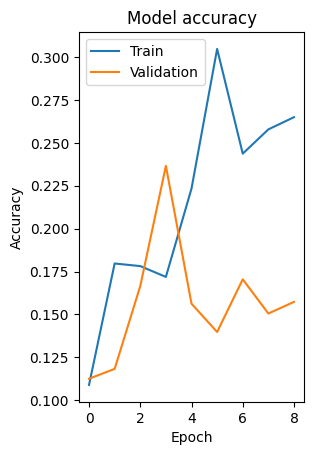

In [51]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

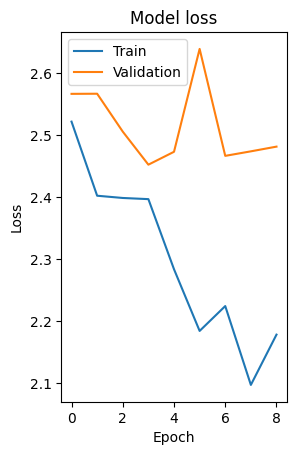

In [46]:
# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

In [47]:
plt.show()

In [41]:
# Evaluate the model on the test set
test_generator = datagen.flow_from_directory(
    dataset_dir,
    target_size=(227, 227),
    batch_size=32,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2909 images belonging to 13 classes.


In [42]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

90/90 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.1468 - loss: 2.4748
Test Accuracy: 16.63%
Test Loss: 2.4916
